# Google Play App Analysis

1. Pick an application from Google Play store with at least 1,000 reviews.
    - (ex) https://play.google.com/store/apps/details?id=com.teamviewer.pilot&hl=en_US&gl=US
2. Crawl review data including USER, DATE, RATING, and TEXT.
3. Tell us about pros and cons about the application based on users’ reviews.
4. Run LDA topic modeling and try to find insights from modeling.
5. Visualize your work.

## Packages installation

```
pandas matplotlib seaborn wordcloud gensim nltk spacy scikit-learn
```

```
# spacy additional download model
python -m spacy download en_core_web_sm
```

## Data Collecting

- Collected 25,000 reviews from [zoom application](https://play.google.com/store/apps/details?id=us.zoom.videomeetings&hl=en_US&gl=US)
- Codes are in `./src/collector.py`

## Pros and Cons

In [1]:
import spacy
from spacy import displacy

import re
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

import pickle
from tqdm.notebook import tqdm
from pathlib import Path
from wordcloud import WordCloud

from gensim.models import TfidfModel, Word2Vec, FastText
from gensim.corpora import Dictionary

from typing import List, Tuple, Union

import matplotlib.font_manager as fm
# need install symbola font to see emoji
# https://fonts2u.com/symbola.font
font_path = [f for f in fm.findSystemFonts() if "Symbola" in f][0]

In [2]:
data_path = Path("./data")
df = pd.read_csv(data_path / "reviews.tsv", sep="\t", encoding="utf-8")

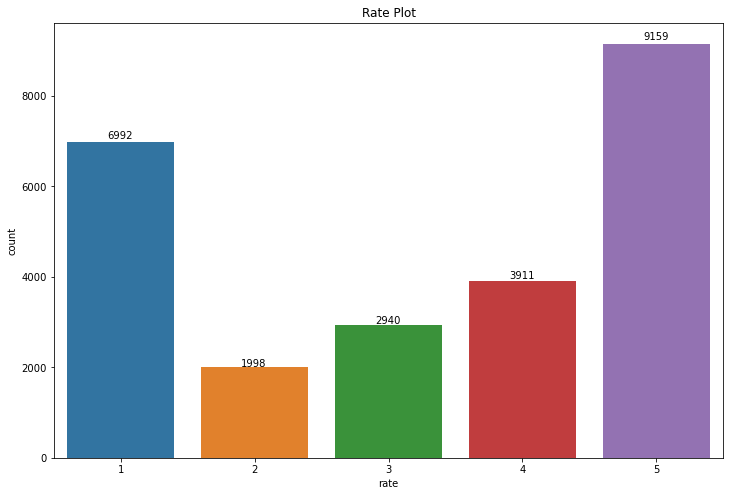

In [3]:
rate_size = df.pivot_table(index="rate",aggfunc="size")

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.countplot(x="rate", data=df, ax=ax)
ax.set_title("Rate Plot")
for i, rate in enumerate(rate_size, 1):
    ax.text(i-1-0.1, rate+rate*0.01, s=f"{rate}")
plt.show()

If we want to see the application's pros and cons, we need to know what people are thinking about this app. 

2 approaches

1. sentimental analysis
    - good or bad 
2. word2vec clustering
    - what kind of words people are talking

In [4]:
get_info = lambda x: (x.lower_, x.lemma_.lower(), x.pos_, x.tag_, x.is_stop)

def process_num_tkns(x: tuple):
    x_lower, x_lemma, x_pos, x_tag = x
    if (x_pos == "NUM") or (x_tag == "CD"):
        return ("[num]", "[num]", x_pos, x_tag)
    else:
        return (x_lower, x_lemma, x_pos, x_tag)
    
def process_remove_s(x: str):
    return x.replace('"', "").replace("-", "")

def preprocessing(txt: spacy.tokens.doc.Doc, stopwords: Union[bool, list]):    
    # tokenize & remove punctuations
    if isinstance(stopwords, bool):
        tkns = [get_info(tkn)[:-1] for tkn in txt if not ((tkn.is_stop) or (tkn.pos_ in ["PUNCT"]) or (tkn.tag_ in [",", "."]))]
    else:
        # specify the stopwords
        tkns = [get_info(tkn)[:-1] for tkn in txt if not ((tkn.tag_ in stopwords) or (tkn.pos_ in stopwords))]
    
    # change NUM to special token [num]
    tkns = [process_num_tkns(x) for x in tkns]
    return tkns

In [5]:
# pipeline = ["tokenizer", "tagger", "lemmatizer", ""]
spacy_nlp = spacy.load("en_core_web_sm")

In [388]:
# with (data_path / "tkns.pickle").open("wb") as file:
#     pickle.dump(list(df["text"].apply(process_remove_s).apply(spacy_nlp)), file)

In [6]:
with (data_path / "tkns.pickle").open("rb") as file:
    doc_data = pickle.load(file)

In [7]:
tkns = []
stopwords = [",", ".", "PUNCT"]
for text in tqdm(doc_data, total=len(doc_data), desc="preprocessing"):
    tkns.append(preprocessing(text, stopwords=stopwords))

preprocessing:   0%|          | 0/25000 [00:00<?, ?it/s]

In [8]:
tkns_remove_stop = []
for text in tqdm(doc_data, total=len(doc_data), desc="preprocessing"):
    tkns_remove_stop.append(preprocessing(text, stopwords=True))

preprocessing:   0%|          | 0/25000 [00:00<?, ?it/s]

In [9]:
def join_tkn_func(x: tuple, idx1: int, idx2: int):
    """
    idx1: token(0) or lemma token(1)
    idx2: pos(2) or tag(3)
    
    - pos: coarse-grained tags, https://universaldependencies.org/docs/u/pos/
    - tag: fine-grained part-of-speech tags
    """
    return f"{x[idx1]}__{x[idx2]}"

def save2documents(tkns: List[Tuple[str]], sv_path: Union[str, Path], idx1: int, idx2: int):
    """
    tkns: list of tuple tokens, (token, lemma, pos, tag, is_stop)
    filename: save filename
    idx1: token(0) or lemma token(1)
    idx2: pos(2) or tag(3)
    
    - pos: coarse-grained tags, https://universaldependencies.org/docs/u/pos/
    - tag: fine-grained part-of-speech tags
    """
    sv_path = Path(sv_path)
    filename = sv_path.name
    with (data_path / filename).open("w", encoding="utf-8") as file:
        for doc in tqdm(tkns, total=len(tkns), desc=f"processing: {filename}"):
            print(" ".join([join_tkn_func(tkn, idx1, idx2) for tkn in doc]), file=file)
             
def to_token(txt, spacy_nlp, token=True, pos=True):
    txt = spacy_nlp(txt)
    idx1 = 0 if token else 1
    idx2 = 2 if pos else 3
    tkns = [get_info(t)[:-1] for t in txt]
    tkns = [process_num_tkns(t) for t in tkns]
    return [join_tkn_func(t, idx1, idx2) for t in tkns]

tokenizer_token_pos = lambda x: to_token(x, spacy_nlp, token=True, pos=True)
tokenizer_token_tag = lambda x: to_token(x, spacy_nlp, token=True, pos=False)
tokenizer_lemma_pos = lambda x: to_token(x, spacy_nlp, token=False, pos=True)
tokenizer_lemma_tag = lambda x: to_token(x, spacy_nlp, token=False, pos=False)

In [10]:
save2documents(tkns, "./data/token_pos.txt", 0, 2)
save2documents(tkns, "./data/token_tag.txt", 0, 3)
save2documents(tkns, "./data/lemma_pos.txt", 1, 2)
save2documents(tkns, "./data/lemma_tag.txt", 1, 3)
save2documents(tkns_remove_stop, "./data/token_pos_rm_stop.txt", 0, 2)
save2documents(tkns_remove_stop, "./data/token_tag_rm_stop.txt", 0, 3)
save2documents(tkns_remove_stop, "./data/lemma_pos_rm_stop.txt", 1, 2)
save2documents(tkns_remove_stop, "./data/lemma_tag_rm_stop.txt", 1, 3)

processing: token_pos.txt:   0%|          | 0/25000 [00:00<?, ?it/s]

processing: token_tag.txt:   0%|          | 0/25000 [00:00<?, ?it/s]

processing: lemma_pos.txt:   0%|          | 0/25000 [00:00<?, ?it/s]

processing: lemma_tag.txt:   0%|          | 0/25000 [00:00<?, ?it/s]

processing: token_pos_rm_stop.txt:   0%|          | 0/25000 [00:00<?, ?it/s]

processing: token_tag_rm_stop.txt:   0%|          | 0/25000 [00:00<?, ?it/s]

processing: lemma_pos_rm_stop.txt:   0%|          | 0/25000 [00:00<?, ?it/s]

processing: lemma_tag_rm_stop.txt:   0%|          | 0/25000 [00:00<?, ?it/s]

## Count Based Analysis

What people are mostly talking about this app by rating, find words about description of this application(using pos `ADJ`, `ADV`)

In [11]:
def load_data(path: Union[str, Path]):
    path = Path(path)
    with path.open("r", encoding="utf-8") as file:
        data = [line.strip().split() for line in file.readlines()]
    return data

In [170]:
rates = df["rate"].values
unique_rates, n_sample_rates = np.unique(rates, return_counts=True)
print(unique_rates)
print(n_sample_rates)
token_pos_path = Path("./data/lemma_pos_rm_stop.txt")
data = load_data(token_pos_path)

[1 2 3 4 5]
[6992 1998 2940 3911 9159]


### whole document

In [77]:
def get_pos_tokens(counter, tags, length=15):
    res = {}
    for w, c in counter.most_common():
        word, tag = w.split("__")
        if tag in tags:
            res[word] = c
        if (length > 0) and (len(res) >= length):
            break
    return dict(sorted(res.items(), key=lambda x: x[1], reverse=True))

In [78]:
whole_word_count = Counter()
for doc in data:
    whole_word_count.update(doc)

In [79]:
length = 100
whole_adjv_word_count = get_pos_tokens(whole_word_count, tags=["ADJ", "ADV"], length=length)
whole_noun_word_count = get_pos_tokens(whole_word_count, tags=["NOUN", "PRON", "PROPN"], length=length)

In [163]:
whole_clouds = {}
whole_clouds["adjv"] = WordCloud(font_path=font_path, width=800, height=800, background_color="white").generate_from_frequencies(whole_adjv_word_count)
whole_clouds["noun"] = WordCloud(font_path=font_path, width=800, height=800, background_color="white").generate_from_frequencies(whole_noun_word_count)

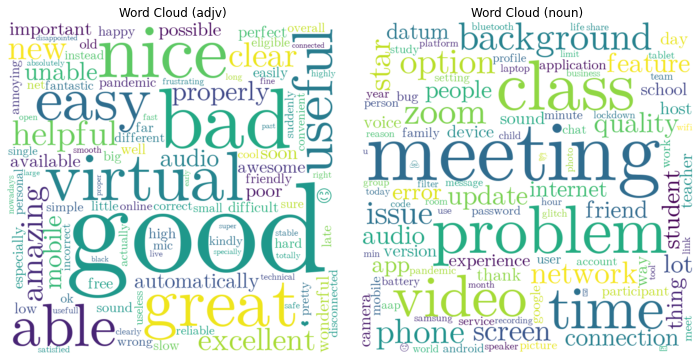

In [164]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for t, ax in zip(["adjv", "noun"], axes.flatten()):
    cloud = whole_clouds[t]
    ax.imshow(cloud.to_array(), interpolation="bilinear")
    ax.set_title(f"Word Cloud ({t})", fontsize=12)
    ax.axis(False)
plt.tight_layout()
plt.show()

In [82]:
whole_vocab = Dictionary(documents=data)
bow_data = [whole_vocab.doc2bow(line) for line in data]
whole_model_tfidf = TfidfModel(corpus=bow_data, dictionary=whole_vocab)

In [83]:
whole_model_tfidf.save("./data/tfidf.model")

In [84]:
# tf(d, t)(term frequency): word 'x' frequency in a single document
# df(t) (document frequency): how many document are there which word 'x' appeared
# idf(d, t)(inverse document frequency): log(number of document / (1+df))
# bigger idf means it is a rare words
rare_ranking = sorted(whole_model_tfidf.idfs.items(), key=lambda x: x[1], reverse=True)
rare_ranking_dict = defaultdict(list)
for i, v in rare_ranking:
    rare_ranking_dict[round(v, 4)].append(whole_vocab[i])

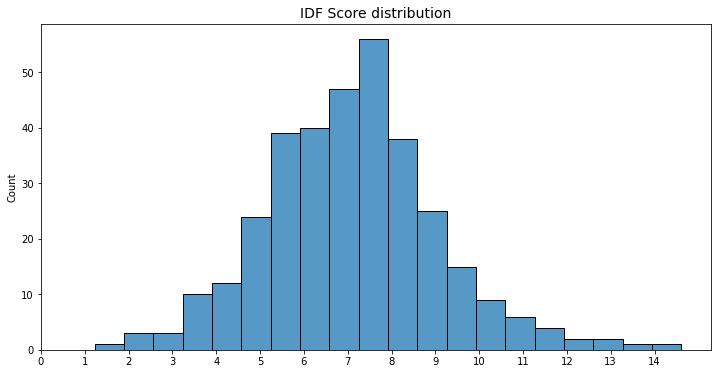

In [85]:
# to rare words might be some not regularized tokens
# should select 9-10 or 10-11 score words can be seen as what people want to say in the app
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(np.array(list(rare_ranking_dict.keys())), bins=20, ax=ax)
ax.set_title("IDF Score distribution", fontsize=14)
ax.set_xticks(np.arange(0, 15))
plt.show()

In [86]:
s_lower = 9
s_higher = 10
rare_words_filtered = list(filter(lambda x: (x[0] >= s_lower) and (x[0] < s_higher), list(rare_ranking_dict.items())))

In [87]:
noun_words = []
adj_words = []
for s, words in rare_words_filtered:
    noun_words.extend([w.split("__")[0] for w in words if w.split("__")[1] == "NOUN"])
    adj_words.extend([w.split("__")[0] for w in words if w.split("__")[1] in ["ADJ"]])

In [126]:
print(noun_words)
print(adj_words)

['classmate', 'answer', 'parent', 'care', '😭', 'form', 'country', 'cell', 'fault', 'event', 'ios', 'working', 'party', 'default', 'interaction', 'virus', 'vedio', 'basis', 'condition', 'consumption', 'mind', '🌟', 'lifesaver', 'saver', 'g', 'source', 'jio', 'delay', 'baground', 'cohost', 'd', 'showing', 'chance', 'cause', 'disturbance', 'interview', 'store', 'instruction', 'web', 'website', 'iam', 'choice', 'noise', 'site', 'backround', '😐', 'trash', 'loss', 'r', 'bcoz', 'discussion', 'step', 'brother', 'cam', 'text', 'level', 'helpfull', '😊', 'rate', 'result', 'ease', 'college', 'smartphone', 'blessing', 'son', 'attendance', 'couple', 'case', 'stop', 'hd', 'court', 'ram', 'creator', 'feedback', 'subscription', 'interruption', 'morning', 'moment', 'opinion', 'disconnect', 'download', 'half', 'classroom', 'self', 'customer', 'colleague', 'show', 'age', 'sir', 'youtube', 'garbage', 'complaint', 'play', 'comment', 'browser', 'gb', 'board', 'second', 'client', 'process', '🙏', 'power', 'coro

### by each rating

In [103]:
word_counts = defaultdict(dict)  # {i: Counter() for i in unique_rates}
for r in unique_rates:
    word_counts[r]["counter"] = Counter()
for doc, r in zip(data, rates):
    word_counts[r]["counter"].update(doc)

In [105]:
length = -1
for r in unique_rates:
    word_counts[r]["adj"] = get_pos_tokens(word_counts[r]["counter"], tags=["ADJ"], length=length)
    word_counts[r]["noun"] = get_pos_tokens(word_counts[r]["counter"], tags=["NOUN"], length=length)

In [107]:
# remove common words in 5 ratings
adj_arrays = []
noun_arrays = []
for r in unique_rates:
    adj_arrays.append(np.array(list(word_counts[r]["adj"].keys())))
    noun_arrays.append(np.array(list(word_counts[r]["noun"].keys())))
    
for r in unique_rates:
    x = list(range(5))
    x.remove(r-1)
    word_counts[r]["noncommon_adj"] = adj_arrays[r-1][np.concatenate(
        [np.isin(adj_arrays[r-1], adj_arrays[i]).reshape(1, -1) for i in x], axis=0).sum(0) != 4]
    word_counts[r]["noncommon_noun"] = noun_arrays[r-1][np.concatenate(
        [np.isin(noun_arrays[r-1], noun_arrays[i]).reshape(1, -1) for i in x], axis=0).sum(0) != 4]

In [160]:
clouds = defaultdict(dict)
length = 100
for r in unique_rates:
    adj_cnt = Counter({w: word_counts[r]["adj"][w] for w in word_counts[r]["noncommon_adj"]}).most_common(length)
    noun_cnt = Counter({w: word_counts[r]["noun"][w] for w in word_counts[r]["noncommon_noun"]}).most_common(length)
    clouds[r]["adj"] = WordCloud(
        font_path=font_path, width=800, height=800, background_color="white", scale=0.9
    ).generate_from_frequencies(dict(adj_cnt))
    clouds[r]["noun"] = WordCloud(
        font_path=font_path, width=800, height=800, background_color="white", scale=0.9
    ).generate_from_frequencies(dict(noun_cnt))

In [157]:
def draw_wordcloud(unique_rates, n_sample_rates, clouds, typ):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    for r, n, ax in zip(unique_rates, n_sample_rates, axes.flatten()):
        cloud = clouds[r][typ]
        ax.imshow(cloud.to_array(), interpolation="bilinear")
        ax.set_title(f"{typ.upper()} Word Cloud at rating {r}(n_sample={n})", fontsize=14)
        ax.axis(False)
    axes[-1][-1].axis(False)
    plt.tight_layout()
    plt.show()

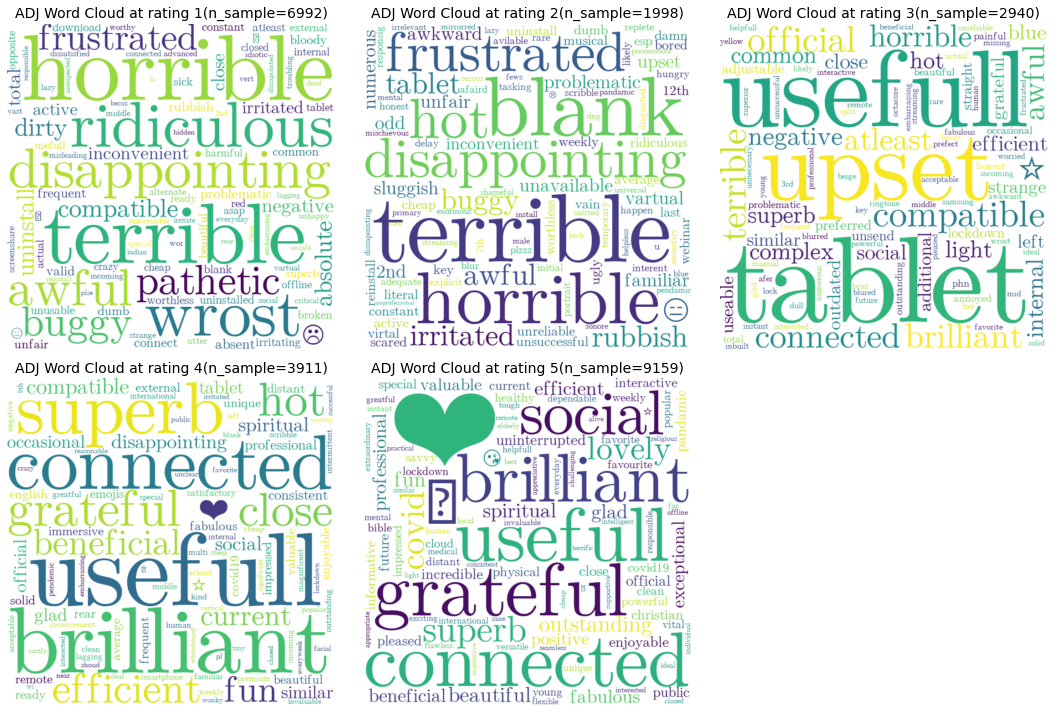

In [161]:
draw_wordcloud(unique_rates, n_sample_rates, clouds, typ="adj")

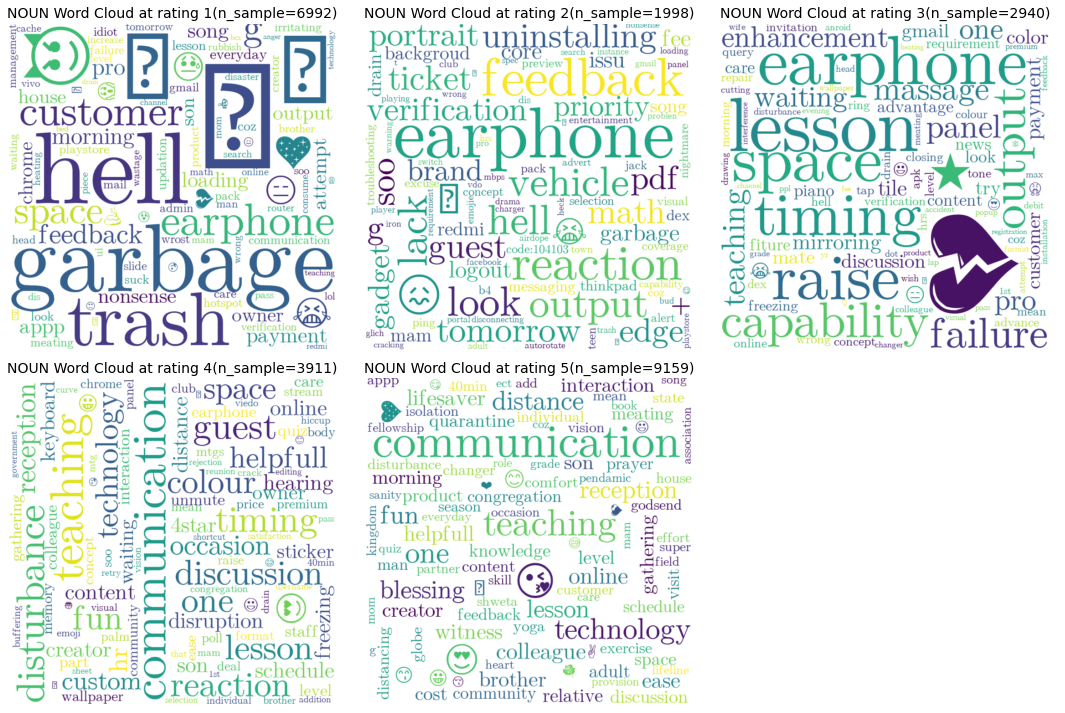

In [162]:
draw_wordcloud(unique_rates, n_sample_rates, clouds, typ="noun")

### Tfidf

In [181]:
docs = defaultdict(list)
for doc, r in zip(data, rates):
    docs[r].append(doc)

# use whole_vocab to tokenize
models = defaultdict(dict)
for r in unique_rates:
    models[r]["docs"] = docs[r]
    models[r]["vocab"] = Dictionary(docs[r])
    models[r]["bow"] = [models[r]["vocab"].doc2bow(line) for line in docs[r]]
    models[r]["model"] = TfidfModel(corpus=models[r]["bow"], dictionary=models[r]["vocab"])

In [182]:
{k: len(v) for k, v in docs.items()}

{2: 1998, 1: 6992, 5: 9159, 3: 2940, 4: 3911}

In [183]:
with (data_path / "tfidf_rate.model").open("wb") as file:
    pickle.dump(models, file)

In [186]:
# tf(d, t)(term frequency): word 'x' frequency in a single document
# df(t) (document frequency): how many document are there which word 'x' appeared
# idf(d, t)(inverse document frequency): log(number of document / (1+df))
# bigger idf means it is a rare words
rare_rankings = defaultdict(dict)
for r in unique_rates:
    rr = sorted(models[r]["model"].idfs.items(), key=lambda x: x[1], reverse=True)
    rr_dict = defaultdict(list)
    for i, v in rr:
        rr_dict[round(v, 4)].append(models[r]["vocab"][i])
    rare_rankings[r]["rr"] = rr
    rare_rankings[r]["rr_dict"] = rr_dict

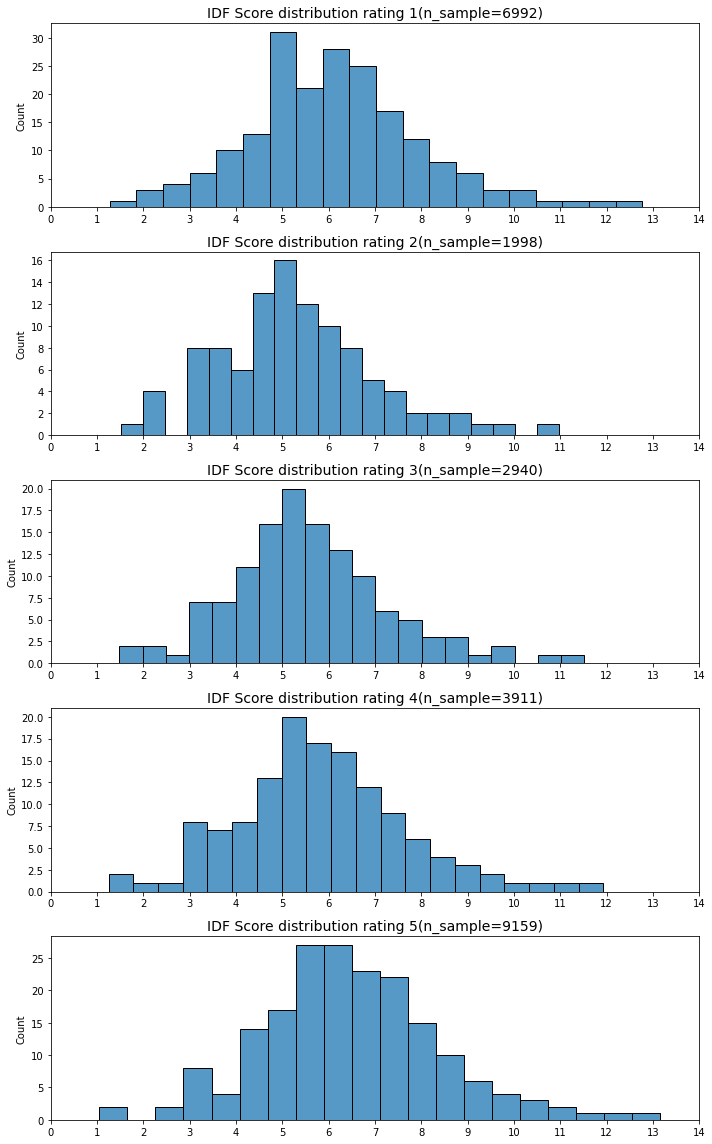

In [187]:
# to rare words might be some not regularized tokens
# should select 9-10 or 10-11 score words can be seen as what people want to say in the app
fig, axes = plt.subplots(5, 1, figsize=(10, 16))
for r, n, ax in zip(unique_rates, n_sample_rates, axes.flatten()):
    sns.histplot(np.array(list(rare_rankings[r]["rr_dict"].keys())), bins=20, ax=ax)
    ax.set_title(f"IDF Score distribution rating {r}(n_sample={n})", fontsize=14)
    ax.set_xticks(np.arange(0, 15))
plt.tight_layout()
plt.show()

## Vector Based

In [189]:
print(unique_rates)
print(n_sample_rates)
token_pos_path = Path("./data/token_pos.txt")
data = load_data(token_pos_path)

[1 2 3 4 5]
[6992 1998 2940 3911 9159]


In [180]:
model_w2v = Word2Vec(data, vector_size=100, window=5, min_count=5, workers=1)

In [234]:
model_w2v.save("./data/w2v_model")

In [191]:
list(spacy_nlp("good"))[0].pos_

'ADJ'

In [198]:
model_w2v.wv.similar_by_key(tokenizer_token_pos("problem")[0])

[('issue__NOUN', 0.9610745906829834),
 ('bug__NOUN', 0.7953856587409973),
 ('issues__NOUN', 0.7755925059318542),
 ('glitch__NOUN', 0.762188196182251),
 ('problems__NOUN', 0.7618309855461121),
 ('error__NOUN', 0.6774190664291382),
 ('bugs__NOUN', 0.6530054211616516),
 ('thing__NOUN', 0.6316841244697571),
 ('disadvantage__NOUN', 0.625320315361023),
 ('gliching__VERB', 0.6070843935012817)]

In [195]:
tokenizer_token_pos("good")[0]

'good__ADJ'

# LDA

In [191]:
print(unique_rates)
print(n_sample_rates)
token_pos_path = Path("./data/lemma_pos.txt")
data = load_data(token_pos_path)

[1 2 3 4 5]
[6992 1998 2940 3911 9159]


In [193]:
from gensim.models import LdaModel, CoherenceModel

In [225]:
datas = {
    "adj": [[tkn.split("__")[0] for tkn in doc if tkn.split("__")[1] in ["ADJ"]] for doc in data],
    "noun": [[tkn.split("__")[0] for tkn in doc if tkn.split("__")[1] in ["NOUN"]] for doc in data]
}
texts = {
    "adj": [" ".join(tkns) for tkns in datas["adj"]],
    "noun": [" ".join(tkns) for tkns in datas["adj"]]
}

In [227]:
lda_vocabs = {
    "adj": Dictionary(datas["adj"]),
    "noun": Dictionary(datas["noun"])
}
print(f"ADJ Number of unique tokens: {len(lda_vocabs['adj'])}")
print(f"NOUN Number of unique tokens: {len(lda_vocabs['noun'])}")

lda_corpus = {
    "adj": [lda_vocabs["adj"].doc2bow(line) for line in datas["adj"]],
    "noun": [lda_vocabs["noun"].doc2bow(line) for line in datas["noun"]]
}

ADJ Number of unique tokens: 2387
NOUN Number of unique tokens: 6146


In [ ]:
# calculate coherence values
max_topics = 30
min_topics = 10
step = 1
lda_models = defaultdict(dict)

search_space = range(min_topics, max_topics+1, step)
for n_topic in tqdm(search_space, total=len(search_space)):
    for typ in ["adj", "noun"]:
        lda = LdaModel(lda_corpus[typ], num_topics=n_topic)
        cm = CoherenceModel(model=lda, corpus=lda_corpus[typ], texts=texts[typ], dictionary=lda_vocabs[typ], coherence="c_v")
        lda_models[n_topic][f"{typ}_lda"] = lda
        lda_models[n_topic][f"{typ}_coherence"] = cm.get_coherence()

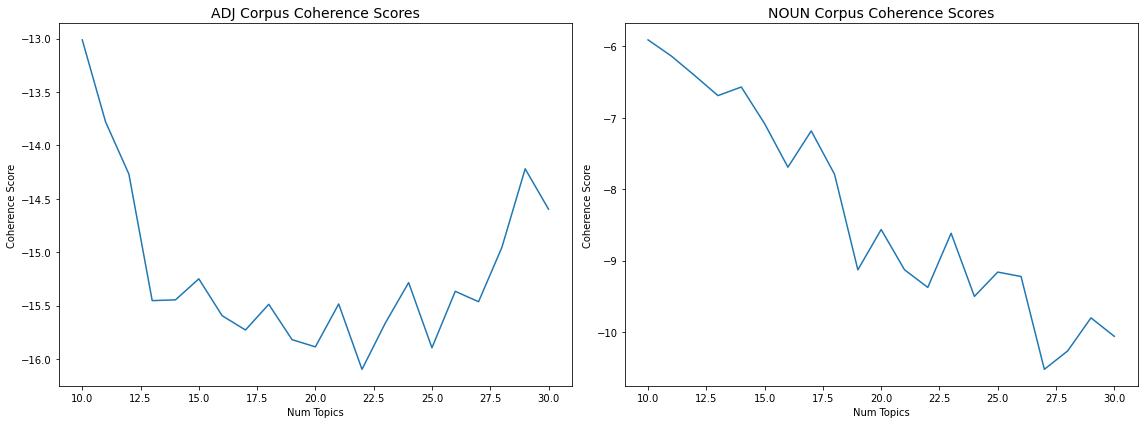

In [215]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for ax, typ, model_dict, in zip(axes.flatten(), ["adj", "noun"], [adj_lda_models, noun_lda_models]):
    ax.plot(np.array(search_space), [model_dict[n_topic]["coherence"] for n_topic in search_space])
    ax.set_xlabel("Num Topics")
    ax.set_ylabel("Coherence Score")
    ax.set_title(f"{typ.upper()} Corpus Coherence Scores", fontsize=14)
    
plt.tight_layout()
plt.show()